In [75]:
Alpha_Name = "AlphaNet_Original_Input_12.22_1d_return"
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
target = "1d_ret"


In [76]:
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
feat_num = 9

In [93]:
time_list = []
data_path = path + "Data/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
time_list

100%|██████████| 26/26 [00:00<00:00, 169862.78it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par',
 '2020-01-01_2020-03-01.par',
 '2020-03-01_2020-06-01.par',
 '2020-06-01_2020-09-01.par',
 '2020-09-01_2021-01-01.par',
 '2021-01-01_2021-03-01.par',
 '2021-03-01_2021-06-01.par']

In [127]:
train_timestamp = time_list[10:23]
test_timestamp = time_list[23:25]
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Pooling_Norm_Daily/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)

for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Pooling_Norm_Daily/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


0         1         2         3         4  \
timestamp           ticker                                                     
2017-06-01 09:30:00 1      -0.032030 -0.030351 -0.025888 -0.032599 -0.030583   
                    2       0.115198  0.064015  0.003181  0.096589  0.069281   
                    4      -0.035533 -0.033544 -0.026819 -0.036200 -0.034352   
                    5      -0.035454 -0.033485 -0.026826 -0.036114 -0.034274   
                    6      -0.034593 -0.032269 -0.025451 -0.035287 -0.032939   
...                              ...       ...       ...       ...       ...   
2020-08-31 09:30:00 688567 -0.023732 -0.022340 -0.022096 -0.025286 -0.022649   
                    688579 -0.023719 -0.022331 -0.022098 -0.025280 -0.022652   
                    300848 -0.021827 -0.021197 -0.021959 -0.023210 -0.021580   
                    688256 -0.019381 -0.016319 -0.007685 -0.018070 -0.014651   
                    688488 -0.023556 -0.022160 -0.021978 -0.024996 -0.022423   

                                   5         6         7         8         9  \
timestamp           ticker                                                     
2017-06-01 09:30:00 1      -0.025381 -0.032185 -0.031334 -0.026733 -0.032219   
                    2       0.029158  0.140727  0.108898  0.038799  0.106258   
                    4      -0.026748 -0.036984 -0.036400 -0.028423 -0.036009   
                    5      -0.026729 -0.036886 -0.036305 -0.028426 -0.035922   
                    6      -0.024459 -0.035942 -0.034821 -0.026302 -0.035047   
...                              ...       ...       ...       ...       ...   
2020-08-31 09:30:00 688567 -0.021895 -0.026931 -0.022935 -0.019685 -0.025258   
                    688579 -0.021932 -0.026921 -0.022937 -0.019723 -0.025247   
                    300848 -0.021785 -0.024663 -0.021797 -0.019611 -0.023413   
                    688256 -0.006587 -0.020302 -0.016600 -0.012504 -0.019910   
                    688488 -0.021738 -0.026708 -0.022728 -0.019573 -0.024971   

                            ...       179       180       181       182  \
timestamp           ticker  ...                                           
2017-06-01 09:30:00 1       ...  0.202477 -0.143039 -0.256013 -0.366939   
                    2       ...  0.671314  0.184342 -0.201855 -0.540092   
                    4       ... -1.842233 -0.282135  0.033548  0.332500   
                    5       ... -0.110005 -0.174890  0.097697  0.297000   
                    6       ...  0.353018  0.117982  0.217030  0.238422   
...                         ...       ...       ...       ...       ...   
2020-08-31 09:30:00 688567  ... -1.264655  0.010542  0.085112  0.193008   
                    688579  ... -0.949787 -0.142977 -0.044077  0.202051   
                    300848  ... -0.655722 -0.185001 -0.144121  0.131426   
                    688256  ... -1.189111 -0.179648 -0.307422 -0.092501   
                    688488  ... -1.357990 -0.150936 -0.082628  0.158021   

                                 183       184       185       186       187  \
timestamp           ticker                                                     
2017-06-01 09:30:00 1      -0.039476 -0.029193  0.234290 -0.040251 -0.030018   
                    2      -0.022683 -0.006433  0.716174 -0.023464 -0.007268   
                    4      -0.059669 -0.072592 -1.858898 -0.060440 -0.073406   
                    5      -0.051786 -0.055340 -0.085545 -0.052558 -0.056155   
                    6      -0.044451 -0.038645  0.388628 -0.045224 -0.039462   
...                              ...       ...       ...       ...       ...   
2020-08-31 09:30:00 688567 -0.056603 -0.140959 -1.245153 -0.058576 -0.143118   
                    688579 -0.179858 -0.238518 -0.930931 -0.181615 -0.240508   
                    300848  8.289077  8.240520 -0.637496  8.272478  8.223870   
                    688256 -0.054180 -0.141019 -1.169756 -0.056157 -0.143178   
                 

timestamp            ticker
2017-06-01 09:30:00  1         0.883160
                     2         0.923032
                     4         0.953857
                     5         0.143962
                     6         0.601226
                                 ...   
2020-08-31 09:30:00  688567    2.364062
                     688579   -0.048042
                     300848   -0.000707
                     688256   -0.498274
                     688488   -0.108318
Name: target, Length: 2831317, dtype: float64

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


0         1         2         3         4  \
timestamp           ticker                                                     
2020-09-01 09:30:00 1       0.042237  0.038469  0.040435  0.035745  0.035584   
                    2       0.219296  0.179366  0.083092  0.186390  0.156594   
                    4      -0.024539 -0.022056 -0.018795 -0.024406 -0.022191   
                    5      -0.025604 -0.022740 -0.019072 -0.025653 -0.022966   
                    6      -0.008479 -0.009039 -0.007554 -0.010226 -0.011208   
...                              ...       ...       ...       ...       ...   
2021-02-26 09:30:00 300928 -0.048738 -0.051700 -0.046231 -0.049781 -0.050937   
                    605277 -0.050258 -0.052849 -0.046772 -0.051014 -0.051778   
                    300926 -0.050295 -0.052859 -0.046679 -0.051106 -0.051830   
                    300927 -0.050040 -0.052437 -0.045943 -0.050727 -0.051427   
                    688617 -0.040608 -0.040845 -0.042351 -0.040698 -0.040721   

                                   5         6         7         8         9  \
timestamp           ticker                                                     
2020-09-01 09:30:00 1       0.035876  0.044323  0.043263  0.043120  0.039105   
                    2       0.054167  0.232375  0.191130  0.074598  0.215398   
                    4      -0.018902 -0.024921 -0.022695 -0.019634 -0.024558   
                    5      -0.019075 -0.026031 -0.023475 -0.019943 -0.025721   
                    6      -0.011562 -0.007484 -0.007454 -0.006434 -0.008532   
...                              ...       ...       ...       ...       ...   
2021-02-26 09:30:00 300928 -0.043684 -0.050322 -0.051491 -0.043545 -0.049025   
                    605277 -0.043902 -0.051817 -0.052488 -0.043757 -0.050405   
                    300926 -0.043768 -0.051920 -0.052598 -0.043925 -0.050482   
                    300927 -0.043527 -0.051671 -0.052244 -0.043381 -0.050199   
                    688617 -0.038259 -0.041922 -0.042858 -0.038046 -0.040275   

                            ...       179       180       181       182  \
timestamp           ticker  ...                                           
2020-09-01 09:30:00 1       ...  2.020290 -0.232304  0.107146  0.229179   
                    2       ...  1.261924 -0.263946  0.031827  0.198519   
                    4       ...  0.042621  0.235833  0.636739  0.199559   
                    5       ... -0.761353 -0.007641 -0.333034 -0.392944   
                    6       ... -1.121630 -0.184707 -0.096741  0.078921   
...                         ...       ...       ...       ...       ...   
2021-02-26 09:30:00 300928  ... -0.081986 -0.294004 -6.320877 -8.348599   
                    605277  ...  0.470681 -0.281023 -0.858502 -0.905048   
                    300926  ... -0.102746 -0.141923  0.058035  0.186700   
                    300927  ... -0.365065 -0.246228  0.024139  0.218021   
                    688617  ... -1.350991 -0.387780 -0.171904  0.165988   

                                 183       184       185       186       187  \
timestamp           ticker                                                     
2020-09-01 09:30:00 1      -0.122547 -0.027395  2.046986 -0.124788 -0.030234   
                    2      -0.118929 -0.075059  1.286025 -0.121170 -0.077749   
                    4      -0.055505  0.005566  0.062968 -0.057902  0.002678   
                    5      -0.092278 -0.051994 -0.743514 -0.094589 -0.054757   
                    6      -0.075654 -0.162072 -1.104818 -0.078006 -0.164572   
...                              ...       ...       ...       ...       ...   
2021-02-26 09:30:00 300928 -0.065819 -0.081803 -0.083343 -0.068256 -0.084977   
                    605277  0.345742  0.351180  0.674201  0.359666  0.365212   
                    300926 -0.059715 -0.075527 -0.111796 -0.061909 -0.078452   
                    300927 -0.044067 -0.062759 -0.471346 -0.045639 -0.065177   
                 

timestamp            ticker
2020-09-01 09:30:00  1        -0.173173
                     2        -0.010624
                     4        -2.126723
                     5        -0.403457
                     6        -0.395240
                                 ...   
2021-02-26 09:30:00  300928    0.805173
                     605277   -0.221223
                     300926    0.640406
                     300927   -0.537128
                     688617   -0.819974
Name: target, Length: 470027, dtype: float64

In [128]:
trainx = torch.from_numpy(np.array(trainx))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([2831317, 189])
trainy.shape:  torch.Size([2831317, 1])
testx.shape:  torch.Size([470027, 189])
testy.shape:  torch.Size([470027, 1])


In [129]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 512
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [130]:
class AlphaNet(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet, self).__init__()
        self.fc1_neuron = int((factor_num * (factor_num - 1) / 2 + 3 * factor_num) * 3)
        self.fc2_neuron = fully_connect_layer_neural
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.fc1 = torch.nn.Linear(self.fc1_neuron, self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.out(x)
        return y_pred

In [131]:
alphanet = AlphaNet(feat_num, 30)
# alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.0001
loss_function = nn.MSELoss()
# optimizer = optim.RMSprop(alphanet.parameters(), lr=LR, alpha=0.9)
optimizer = optim.Adam(alphanet.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 8
loss_list = []

# for epoch in range(epoch_num):
#     optimizer.step()
#     scheduler.step()
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
# plt.plot(range(epoch_num),lr_list,color = 'r')

for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data).float()
        label = Variable(label).float()
        pred = alphanet(data)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)

  0%|          | 0/8 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(189, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=189, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


 12%|█▎        | 1/8 [00:51<06:01, 51.69s/it]

Epoch:  1  loss:  0.9558354100098096


 25%|██▌       | 2/8 [01:41<05:01, 50.29s/it]

Epoch:  2  loss:  0.9510131922317044


 38%|███▊      | 3/8 [02:31<04:11, 50.23s/it]

Epoch:  3  loss:  0.9505015946917569


 50%|█████     | 4/8 [03:21<03:20, 50.22s/it]

Epoch:  4  loss:  0.9501664446375091


 62%|██████▎   | 5/8 [04:11<02:30, 50.20s/it]

Epoch:  5  loss:  0.9497865789954603


 75%|███████▌  | 6/8 [05:02<01:40, 50.43s/it]

Epoch:  6  loss:  0.949600002112412


 88%|████████▊ | 7/8 [05:52<00:50, 50.35s/it]

Epoch:  7  loss:  0.9493419317997183


100%|██████████| 8/8 [06:44<00:00, 50.56s/it]

Epoch:  8  loss:  0.949222983395266


In [132]:
# optimizer = optim.RMSprop(alphanet.parameters(), lr=LR/1000, alpha=0.9)
optimizer = optim.Adam(alphanet.parameters(), lr=LR/100)
for epoch in tqdm(range(5)):
    total_loss = 0
    for _, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data).float()
        label = Variable(label).float()
        pred = alphanet(data)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)

 20%|██        | 1/5 [00:51<03:24, 51.09s/it]

Epoch:  1  loss:  0.9488891958020935


 40%|████      | 2/5 [01:40<02:31, 50.37s/it]

Epoch:  2  loss:  0.9489267790576857


 60%|██████    | 3/5 [02:31<01:40, 50.30s/it]

Epoch:  3  loss:  0.9489457118552449


 80%|████████  | 4/5 [03:21<00:50, 50.16s/it]

Epoch:  4  loss:  0.9488421440485931


100%|██████████| 5/5 [04:10<00:00, 50.16s/it]

Epoch:  5  loss:  0.9489094466260299


In [116]:
optimizer = optim.RMSprop(alphanet.parameters(), lr=LR/1000, alpha=0.9)
# optimizer = optim.Adam(alphanet.parameters(), lr=LR/10000)
for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data).float()
        label = Variable(label).float()
        pred = alphanet(data)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)

 12%|█▎        | 1/8 [01:13<08:33, 73.34s/it]

Epoch:  1  loss:  0.9314294079078423


 25%|██▌       | 2/8 [02:26<07:19, 73.28s/it]

Epoch:  2  loss:  0.9314343533300267


 38%|███▊      | 3/8 [03:40<06:08, 73.71s/it]

Epoch:  3  loss:  0.9314323515627201


 38%|███▊      | 3/8 [04:31<07:31, 90.34s/it]


KeyboardInterrupt: 

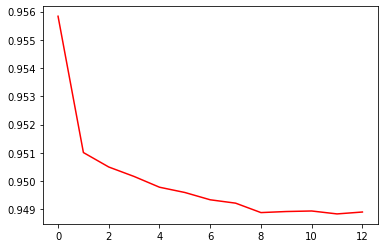

In [133]:
plt.plot(loss_list,color = 'r')

In [134]:
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())
# final = pd.concat([test_target, pd.DataFrame(pred_list)], axis=1)
# alpha_name = 'AlphaNetV1_Original_Input_1208'
# final.rename(columns={0: alpha_name, 'ticker': 'symbol'}, inplace=True)
# final = final.reindex(columns=['symbol', 'timestamp', alpha_name,'target'])
# final.set_index(['symbol', 'timestamp']).to_csv(output_path + "result/"+'%s_%s.csv' % (time_start, time_end))

In [135]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_12.22_1d_return
0,2020-09-01 09:30:00,1,-0.173173,-0.009016
1,2020-09-01 09:30:00,2,-0.010624,-0.001571
2,2020-09-01 09:30:00,4,-2.126723,-0.000391
3,2020-09-01 09:30:00,5,-0.403457,0.034350
4,2020-09-01 09:30:00,6,-0.395240,-0.000946
...,...,...,...,...
470022,2021-02-26 09:30:00,300928,0.805173,0.065530
470023,2021-02-26 09:30:00,605277,-0.221223,-0.029789
470024,2021-02-26 09:30:00,300926,0.640406,0.091690
470025,2021-02-26 09:30:00,300927,-0.537128,-0.014228


In [136]:
test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]

'2020-09-01_2021-03-01.par'

In [137]:
final.to_parquet('/home/wuwenjun/Alpha_Factor/AlphaNet_Original_Input_12.22_1d_return/result/'
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])